In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import constants
from scipy.stats import cauchy
from scipy import signal

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Sizing Fabry Perot Interferometer

| Quantum dot emission            | Energy           | Frequency  |
|----------------|------------------|-----------------------------|
| Center         | (1.38 - 2.07) eV | (3.33 - 5.00) $10^{14}$ Hz  |
| Spectral range | (100 - 500) µeV   | (24.20 - 120.90) $10^9$ Hz |

ThorLab-mirrors are available with R = 93%, these should be a suitable starting point for the calculation:

In [3]:
R_1 = R_2 = 0.93

In [4]:
v_dot_spectral_range_thin = 24.20 * 10**9
v_dot_spectral_range_broad = 120.90 * 10**9

The free spectral range $\Delta \nu_{\rm FSR}$ is given by
$$\Delta \nu_{\rm FSR} = \frac{c}{2l}$$
where $c$ is the speed of light in the medium and $l$ is geometrical length of the two mirror Fabry-Pérot.

The free spectral range $\Delta \nu_{\rm FSR}$ of the Fabry-Perot needs to greater than the spectral range of the quantum dot emission.

Therefore I assume two values for the two extremes of the spectral ranges of the dot with a buffer:

In [5]:
buffer = 10
delta_v_FSR_thin = v_dot_spectral_range_thin * buffer
delta_v_FSR_broad = v_dot_spectral_range_broad * buffer

l_thin = constants.c / (2 * delta_v_FSR_thin)
l_broad = constants.c / (2 * delta_v_FSR_broad)

print(f"l_thin = {l_thin * 10**3:.02f} mm")
print(f"l_broad = {l_broad * 10**3:.02f} mm")

l_thin = 0.62 mm
l_broad = 0.12 mm


 The FWHM linewidth $\Delta \nu_{\rm Airy}$ of the Airy distribution is given by

$$\Delta \nu_{\rm Airy} = \Delta \nu_{\rm FSR} \frac{2}{\pi} \arcsin \left( \frac{1 - \sqrt{R_1 R_2}}{2 \sqrt[4]{R_1 R_2}} \right)$$

In [6]:
def calc_delta_v_Airy(delta_v_FSR, R_1, R_2):
    return delta_v_FSR * 2 / np.pi * np.arcsin((1-np.sqrt(R_1*R_2))/(2*(R_1 * R_2)**(1/4)))

In [7]:
delta_v_Airy_thin = calc_delta_v_Airy(delta_v_FSR_thin, R_1, R_2)
delta_v_Airy_broad = calc_delta_v_Airy(delta_v_FSR_broad, R_1, R_2)

print(f"delta_E_Airy_thin = {delta_v_Airy_thin * constants.h / constants.e * 10**6:.02f} µeV")
print(f"delta_E_Airy_broad = {delta_v_Airy_broad * constants.h / constants.e * 10**6:.02f} µeV")

delta_E_Airy_thin = 23.13 µeV
delta_E_Airy_broad = 115.55 µeV


$$A'_{trans}(\nu)=\frac{(1-R_1)(1-R_2)}{(1-\sqrt{R_1R_2})^2+4\sqrt{R_1R_2}\sin^2(\phi)}$$

with

$$\phi(\nu)=\frac{\pi\nu}{\Delta \nu_{FSR}}$$

In [8]:
def delta_v_FSR(l):
    return constants.c / (2*l)


def phi(v, l):
    return constants.pi * v / delta_v_FSR(l)


def A_prime_trans(v, R_1, R_2, l):
    return (1-R_1) * (1-R_2) / ((1-np.sqrt(R_1*R_2))**2+4*np.sqrt(R_1*R_2)*np.sin(phi(v,l))**2)

### Goal:
Resolve QDs with paramters seen in table at the top.

Describe dot spectrum with cauchy distribution.

$$\Phi_{dot}(\nu) = \frac{1}{\pi \cdot v\_dot\_spectral\_range \cdot 0.5 \left[1+\left(\frac{\nu - \nu\_dot\_center}{v\_dot\_spectral\_range \cdot 0.5}\right)^2\right]}$$

In [9]:
def calc_phi_dot(v, v_dot_center, v_dot_spectral_range):
    return cauchy.pdf(v, loc=v_dot_center, scale=v_dot_spectral_range * 0.5)

In [10]:
v_dot_center = 4 * 10**14 # in Hz
number_of_points = 4000
number_of_airy_peaks = 4

v_boundaries_thin = (v_dot_center - delta_v_FSR(l_thin)*number_of_airy_peaks/2, v_dot_center + delta_v_FSR(l_thin)*number_of_airy_peaks/2)
v_boundaries_broad = (v_dot_center - delta_v_FSR(l_broad)*number_of_airy_peaks/2, v_dot_center + delta_v_FSR(l_broad)*number_of_airy_peaks/2)

V_thin = np.linspace(*v_boundaries_thin, number_of_points)
V_broad = np.linspace(*v_boundaries_broad, number_of_points)

phi_dot_thin = calc_phi_dot(V_thin, v_dot_center, v_dot_spectral_range_thin)
phi_dot_broad = calc_phi_dot(V_broad, v_dot_center, v_dot_spectral_range_broad)

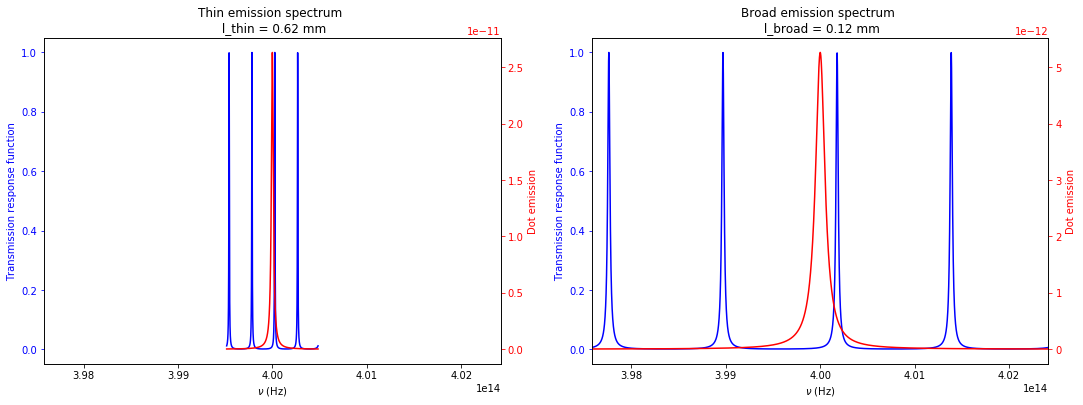

In [11]:
fig, (ax1_thin, ax1_broad) = plt.subplots(1, 2)
fig.set_size_inches(18, 6)

ax1_thin.plot(V_thin, A_prime_trans(V_thin, R_1, R_2, l_thin), "b", label="Transmission Fabry Perot")
ax1_thin.set_xlim(v_boundaries_broad)
ax1_thin.set_xlabel(r"$\nu$ (Hz)")
ax1_thin.set_ylabel("Transmission response function", color="b")
ax1_thin.tick_params("y", colors="b")
ax1_thin.set_title(f"Thin emission spectrum \n l_thin = {l_thin * 10**3:.02f} mm")

ax2_thin = ax1_thin.twinx()
ax2_thin.plot(V_thin, phi_dot_thin, "r", label=r"$\Phi_{dot}(\nu)$")
ax2_thin.set_ylabel("Dot emission", color="r")
ax2_thin.tick_params("y", colors="r")

ax1_broad.plot(V_broad, A_prime_trans(V_broad, R_1, R_2, l_broad), "b", label="Transmission Fabry Perot")
ax1_broad.set_xlim(v_boundaries_broad)
ax1_broad.set_xlabel(r"$\nu$ (Hz)")
ax1_broad.set_ylabel("Transmission response function", color="b")
ax1_broad.tick_params("y", colors="b")
ax1_broad.set_title(f"Broad emission spectrum \n l_broad = {l_broad * 10**3:.02f} mm")

ax2_broad = ax1_broad.twinx()
ax2_broad.plot(V_broad, phi_dot_broad, "r", label=r"$\Phi_{dot}(\nu)$")
ax2_broad.set_ylabel("Dot emission", color="r")
ax2_broad.tick_params("y", colors="r")

The output-photon-flux of the scanning Fabry-Perot-interferometer is described with the convolution of the emission of the QD $E_{dot}(\nu)$ and the transmission of the Fabry-perot $A'_{trans}(\nu)$.

$$\Phi_{fabry,perot, unnormalized} = \int^{v\_dot\_center + \Delta \nu_{FSR} \cdot number\_of\_airy\_peaks}_{v\_dot\_center - \Delta \nu_{FSR} \cdot number\_of\_airy\_peaks} d\nu' E_{dot}(\nu')A'_{trans}(\nu - \nu')$$

it can then be normalized with the integral of $A'_{trans}(\nu)$ over one period:

$$normalization\_factor = \int^{v\_dot\_center + \Delta \nu_{FSR} \cdot number\_of\_airy\_peaks \cdot 0.5}_{v\_dot\_center - \Delta \nu_{FSR} \cdot number\_of\_airy\_peaks \cdot 0.5} d\nu A'_{trans}(\nu) = \frac{\sum A'_{trans}(\nu)}{number\_of\_airy\_peaks} $$

Therefore the output-photon-flux of the scanning Fabry-Perot-interferometer is:
$$\Rightarrow \Phi_{fabry,perot} = \frac{\Phi_{fabry,perot, unnormalized}}{normalization\_factor}$$

In [12]:
def calc_phi_fabry_perot(V, v_dot_center, v_dot_spectral_range, R_1, R_2, l, number_of_airy_peaks):
    phi_fabry_perot_unnormalized = signal.convolve(calc_phi_dot(V, v_dot_center, v_dot_spectral_range), A_prime_trans(V, R_1, R_2, l))
    normalization_factor = sum(A_prime_trans(V, R_1, R_2, l)) / number_of_airy_peaks
    phi_fabry_perot = phi_fabry_perot_unnormalized / normalization_factor

    v_conv_boundaries = (v_dot_center - delta_v_FSR(l)*number_of_airy_peaks, v_dot_center + delta_v_FSR(l)*number_of_airy_peaks)
    V_2 = np.linspace(*v_conv_boundaries, number_of_points*2-1)
    
    return  V_2, phi_fabry_perot

In [13]:
V_2_thin, phi_fabry_perot_thin = calc_phi_fabry_perot(V_thin, v_dot_center, v_dot_spectral_range_thin, R_1, R_2, l_thin, number_of_airy_peaks)
V_2_broad, phi_fabry_perot_broad = calc_phi_fabry_perot(V_broad, v_dot_center, v_dot_spectral_range_broad, R_1, R_2, l_broad, number_of_airy_peaks)

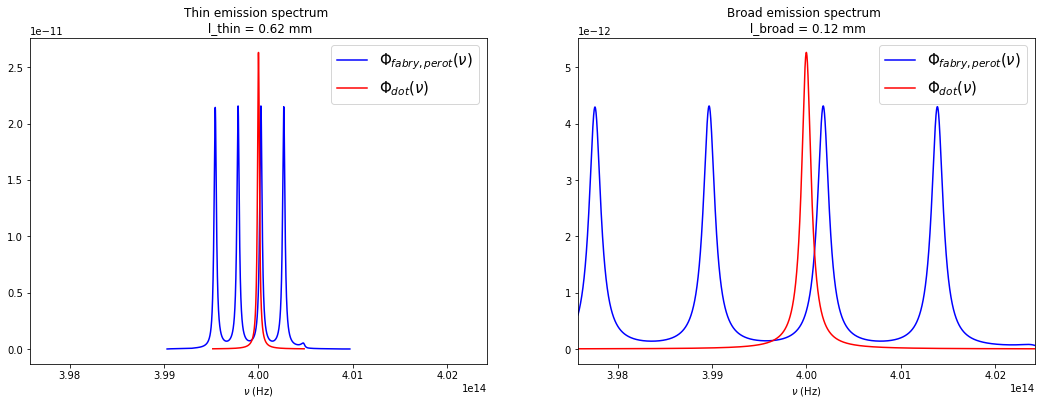

In [14]:
plt.figure(figsize=(18, 6))

plt.subplot(1, 2, 1)
plt.plot(V_2_thin, phi_fabry_perot_thin, "b", label=r"$\Phi_{fabry,perot}(\nu)$")
plt.plot(V_thin, phi_dot_thin, "r" , label=r"$\Phi_{dot}(\nu)$")
plt.xlabel(r"$\nu$ (Hz)")
plt.xlim(v_boundaries_broad)
plt.legend(fontsize=15)
plt.title(f"Thin emission spectrum \n l_thin = {l_thin * 10**3:.02f} mm")

plt.subplot(1, 2, 2)
plt.plot(V_2_broad, phi_fabry_perot_broad, "b", label=r"$\Phi_{fabry,perot}(\nu)$")
plt.plot(V_broad, phi_dot_broad, "r" , label=r"$\Phi_{dot}(\nu)$")
plt.xlabel(r"$\nu$ (Hz)")
plt.xlim(v_boundaries_broad)
plt.legend(fontsize=15)
plt.title(f"Broad emission spectrum \n l_broad = {l_broad * 10**3:.02f} mm")

plt.show()

To better compare $\Phi_{dot}(\nu)$ and $\Phi_{fabry,perot}$, we need to shift them relative to each other:

In [15]:
def shift_phi_fabry_perot(phi_fabry_perot, V, V_2, phi_dot):
    position_V_dot_peak = signal.find_peaks(phi_dot)[0][0]
    position_airy_peaks = signal.find_peaks(phi_fabry_perot)[0]
    
    position_dot_peak = (np.abs(V_2 - V[position_V_dot_peak])).argmin()
    position_closest_airy_peak = position_airy_peaks[(np.abs(V_2[position_airy_peaks] - V[position_V_dot_peak])).argmin()]    
    phi_fabry_perot_shifted = np.roll(phi_fabry_perot, position_dot_peak - position_closest_airy_peak)
    return phi_fabry_perot_shifted, position_dot_peak, position_V_dot_peak

In [16]:
phi_fabry_perot_shifted_thin, position_closest_airy_peak_thin, position_dot_peak_thin  = shift_phi_fabry_perot(phi_fabry_perot_thin, V_thin, V_2_thin, phi_dot_thin)
phi_fabry_perot_shifted_broad, position_closest_airy_peak_broad, position_dot_peak_broad = shift_phi_fabry_perot(phi_fabry_perot_broad, V_broad, V_2_broad, phi_dot_broad)

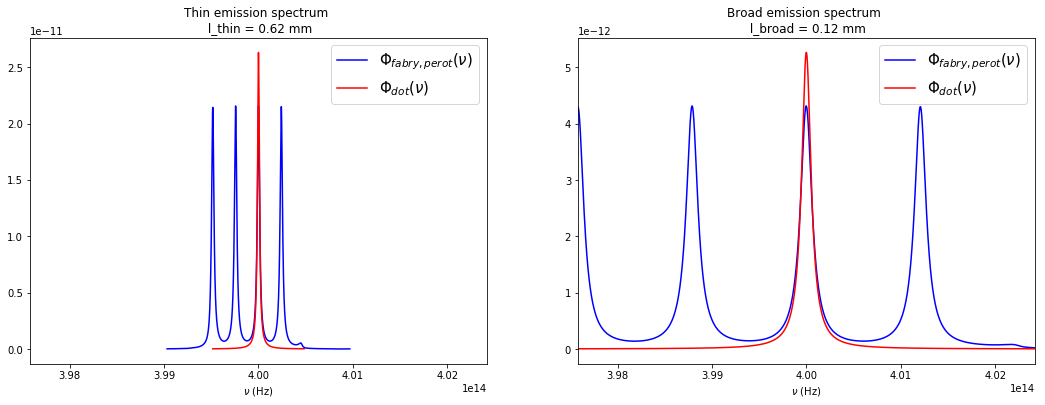

In [17]:
plt.figure(figsize=(18, 6))

plt.subplot(1, 2, 1)
plt.plot(V_2_thin, phi_fabry_perot_shifted_thin, "b", label=r"$\Phi_{fabry,perot}(\nu)$")
plt.plot(V_thin, phi_dot_thin, "r" , label=r"$\Phi_{dot}(\nu)$")
plt.xlabel(r"$\nu$ (Hz)")
plt.xlim(v_boundaries_broad)
plt.legend(fontsize=15)
plt.title(f"Thin emission spectrum \n l_thin = {l_thin * 10**3:.02f} mm")

plt.subplot(1, 2, 2)
plt.plot(V_2_broad, phi_fabry_perot_shifted_broad, "b", label=r"$\Phi_{fabry,perot}(\nu)$")
plt.plot(V_broad, phi_dot_broad, "r" , label=r"$\Phi_{dot}(\nu)$")
plt.xlabel(r"$\nu$ (Hz)")
plt.xlim(v_boundaries_broad)
plt.legend(fontsize=15)
plt.title(f"Broad emission spectrum \n l_broad = {l_broad * 10**3:.02f} mm")


plt.show()

## Calculating Error:

$$ Error = \frac{\int^{v\_dot\_center + \Delta \nu_{FSR} \cdot 0.5}_{v\_dot\_center - \Delta \nu_{FSR} \cdot 0.5} \left|\Phi_{\text{fabry,perot,shifted}}(\nu) - \Phi_{\text{dot}}(\nu)\right| d \nu }{\int^{v\_dot\_center + \Delta \nu_{FSR} \cdot 0.5}_{v\_dot\_center - \Delta \nu_{FSR} \cdot 0.5} \Phi_{\text{dot}}(\nu) d \nu}$$

In terms of indices of V_2 this is equal to boundaries of (number_of_points / number_of_airy_peaks) around the peak of the dot.

In [18]:
def calc_error(phi_fabry_perot_shifted, phi_dot, position_closest_airy_peak, position_dot_peak,  number_of_points, number_of_airy_peaks):
    range_ = (-int(number_of_points / number_of_airy_peaks / 2), int(number_of_points / number_of_airy_peaks / 2))
    boundaries_fabry_perot = position_closest_airy_peak + range_
    boundaries_dot = position_dot_peak + range_
    numerator = np.abs(phi_fabry_perot_shifted[slice(*boundaries_fabry_perot)] - phi_dot[slice(*boundaries_dot)])
    denominator = phi_dot[slice(*boundaries_dot)]
    return numerator, denominator, boundaries_fabry_perot, boundaries_dot

In [19]:
numerator_thin, denominator_thin, boundaries_fabry_perot_thin, boundaries_dot_thin  = calc_error(phi_fabry_perot_shifted_thin, phi_dot_thin, position_closest_airy_peak_thin, position_dot_peak_thin, number_of_points, number_of_airy_peaks)
numerator_broad, denominator_broad, boundaries_fabry_perot_broad, boundaries_dot_broad = calc_error(phi_fabry_perot_shifted_broad, phi_dot_broad, position_closest_airy_peak_broad, position_dot_peak_broad, number_of_points, number_of_airy_peaks)

error_thin = np.sum(numerator_thin) / np.sum(denominator_thin)
error_broad = np.sum(numerator_broad) / np.sum(denominator_broad)

In [20]:
print(f"Error for thin end of the width of the emission spectrum: {error_thin:.2%}")
print(f"Error for broad end of the width of the emission spectrum: {error_broad:.2%}")

Error for thin end of the width of the emission spectrum: 17.85%
Error for broad end of the width of the emission spectrum: 17.87%


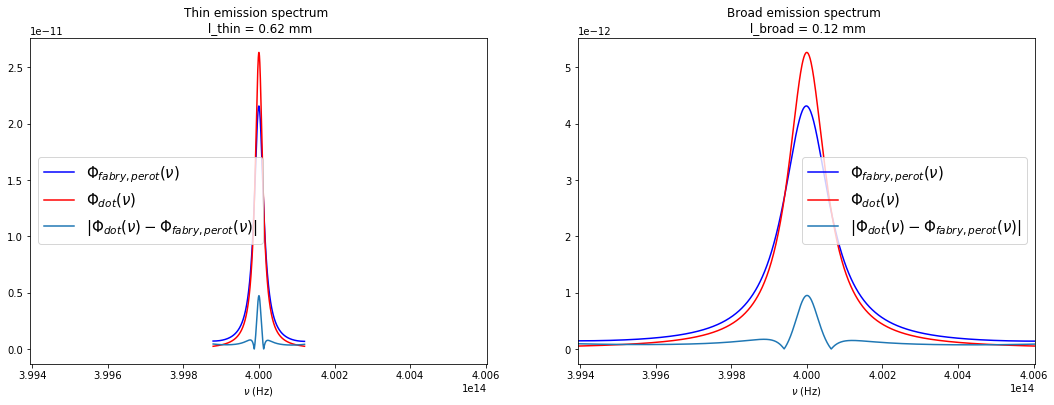

In [21]:
plt.figure(figsize=(18, 6))

plt.subplot(1, 2, 1)
plt.plot(V_2_thin[slice(*boundaries_fabry_perot_thin)], phi_fabry_perot_shifted_thin[slice(*boundaries_fabry_perot_thin)], "b", label=r"$\Phi_{fabry,perot}(\nu)$")
plt.plot(V_thin[slice(*boundaries_dot_thin)], phi_dot_thin[slice(*boundaries_dot_thin)], "r" , label=r"$\Phi_{dot}(\nu)$")
plt.plot(V_thin[slice(*boundaries_dot_thin)], numerator_thin, label=r"$|\Phi_{dot}(\nu) - \Phi_{fabry,perot}(\nu)|$")
plt.xlabel(r"$\nu$ (Hz)")
plt.legend(fontsize=15)
plt.xlim(min(V_broad[slice(*boundaries_dot_broad)]), max(V_broad[slice(*boundaries_dot_broad)]))
plt.title(f"Thin emission spectrum \n l_thin = {l_thin * 10**3:.02f} mm")

plt.subplot(1, 2, 2)
plt.plot(V_2_broad[slice(*boundaries_fabry_perot_broad)], phi_fabry_perot_shifted_broad[slice(*boundaries_fabry_perot_broad)], "b", label=r"$\Phi_{fabry,perot}(\nu)$")
plt.plot(V_broad[slice(*boundaries_dot_broad)], phi_dot_broad[slice(*boundaries_dot_broad)], "r" , label=r"$\Phi_{dot}(\nu)$")
plt.plot(V_broad[slice(*boundaries_dot_broad)], numerator_broad, label=r"$|\Phi_{dot}(\nu) - \Phi_{fabry,perot}(\nu)|$")
plt.xlabel(r"$\nu$ (Hz)")
plt.legend(fontsize=15)
plt.xlim(min(V_broad[slice(*boundaries_dot_broad)]), max(V_broad[slice(*boundaries_dot_broad)]))
plt.title(f"Broad emission spectrum \n l_broad = {l_broad * 10**3:.02f} mm")


plt.show()

## Thermal drift:

### 1) How much does the phase shift with a change of the length between the mirrors $l$?